In [1]:
%pylab inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = "jet"
import healpy as h
from modules import binned_master

Populating the interactive namespace from numpy and matplotlib


# Master algorithm

The masked $C_{\ell}$ is related to the unmasked $C_{\ell}$ via the following relation,
$$\tilde{C}_{\ell} = \sum_{\ell'} M_{\ell \ell'} C_{\ell'}$$

# Reading in the mask

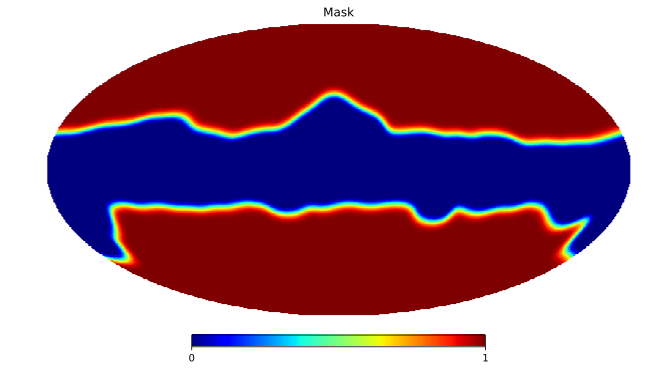

In [2]:
mask=h.read_map("./data/mask.fits",verbose=False) ; fsky=sum(mask)/size(mask)
nside=h.get_nside(mask) ; lmax=2*nside ; ell=arange(lmax+1)
h.mollview(mask,title="Mask")

# Computing the coupling matrix $M_{\ell \ell'}$ and its binned version

In [3]:
cmblmin=2 ; cmblmax=lmax ; masklmax=2*nside
bm=binned_master.binned_master(mask,cmblmin,cmblmax,masklmax)
bm.setup_binning(20)

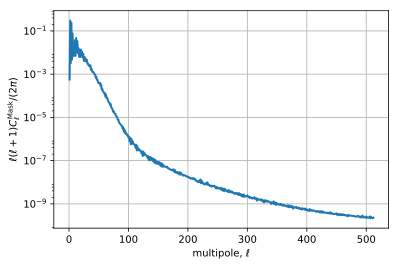

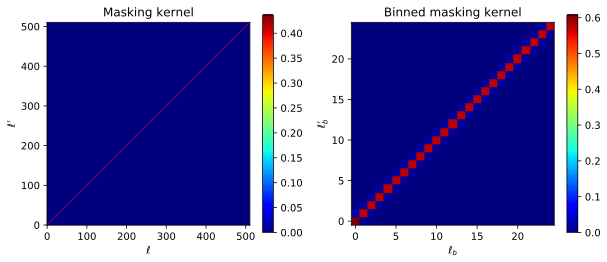

In [4]:
figure()
ell=arange(masklmax+1)
plot(ell,ell*(ell+1)*bm.clmask/2/pi,lw=2)
xlabel("multipole, $\ell$")
ylabel(r"$\ell(\ell+1)C^{\rm Mask}_{\ell}/(2 \pi)$")
grid()
semilogy()

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(10, 4))
im1=ax1.imshow(bm.mllp,origin="lower")
f.colorbar(im1,ax=ax1)
ax1.set_title("Masking kernel")
ax1.set_xlabel("$\ell$") ; ax1.set_ylabel("$\ell'$")
im2=ax2.imshow(bm.mbbp,origin="lower")
f.colorbar(im2,ax=ax2)
ax2.set_title("Binned masking kernel")
ax2.set_xlabel("$\ell_b$") ; ax2.set_ylabel("$\ell_b'$")

# Generating a simulated CMB map and computing its power spectrum

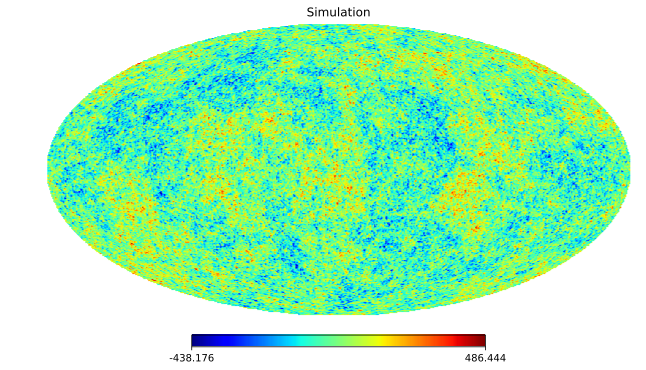

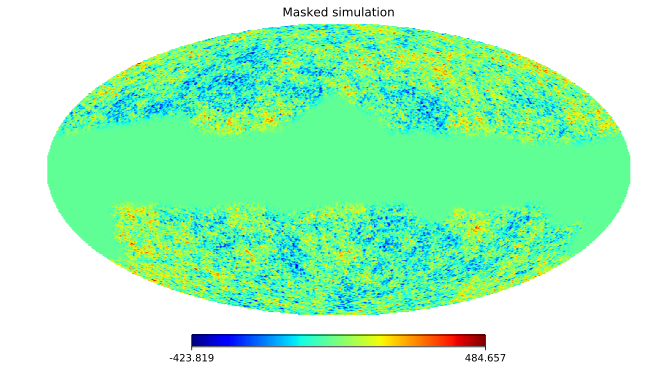

In [5]:
clthry=h.read_cl("./data/thrycl.fits")
sim=h.synfast(clthry[0,:],nside,lmax=cmblmax,verbose=False,pixwin=False)
h.mollview(sim,title="Simulation")
h.mollview(sim*mask,title="Masked simulation")

## Power spectrum

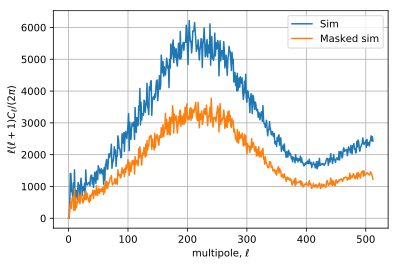

In [6]:
clsim=h.alm2cl(h.map2alm(sim,lmax=cmblmax))
clsim_masked=h.alm2cl(h.map2alm(sim*mask,lmax=cmblmax))
ell=arange(cmblmax+1)

figure()
plot(ell,ell*(ell+1)*clsim/(2.*pi),label="Sim")
plot(ell,ell*(ell+1)*clsim_masked/(2.*pi),label="Masked sim")
xlabel("multipole, $\ell$")
ylabel("$\ell(\ell+1)C_{\ell}/(2 \pi)$")
legend(loc=0)
grid()

# Evaluating the master corrected spectrum: 
$$C_{\ell} = \sum_{\ell'} M^{-1}_{\ell \ell'} \tilde{C}_{\ell'}$$

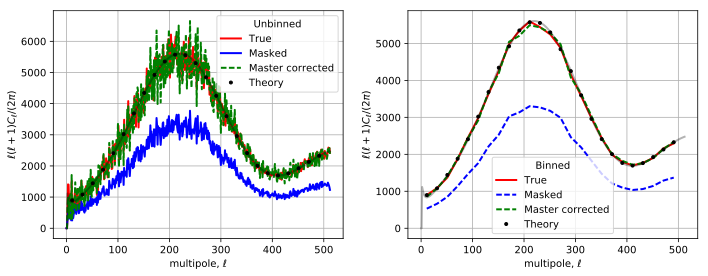

In [7]:
clmcs=bm.return_mcs(clsim_masked)                # Computing the master corrected spectrum
lbin,clb=bm.return_binned_spectra(clsim)         # Binning the true spectrum
lbin,clbm=bm.return_binned_spectra(clsim_masked) # Binning the masked spectrum
lbin,clbmcs=bm.return_bmcs(clsim_masked)         # Computing the binned master corrected spetrum
lbin,cltb=bm.return_binned_spectra(clthry[0,:cmblmax+1])         # Computing the binned master corrected spetrum

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(10, 4))
ax1.plot(ell,ell*(ell+1)*clsim/2./pi,"r-",lw=2,label="True")
ax1.plot(ell,ell*(ell+1)*clsim_masked/2./pi,"b-",lw=2,label="Masked")
ax1.plot(ell,ell*(ell+1)*clmcs/2./pi,"g--",lw=2,label="Master corrected")
ax1.plot(ell,ell*(ell+1)*clthry[0,:cmblmax+1]/2./pi,"k-",lw=2,alpha=0.3)
ax1.plot(lbin,cltb,"k.",lw=2,label="Theory")
ax1.set_xlabel("multipole, $\ell$")
ax1.set_ylabel("$\ell(\ell+1)C_{\ell}/(2 \pi)$")
ax1.legend(loc=0,title="Unbinned")
ax1.grid()
ax2.plot(lbin,clb,"r-",lw=2,label="True")
ax2.plot(lbin,clbm,"b--",lw=2,label="Masked")
ax2.plot(lbin,clbmcs,"g--",lw=2,label="Master corrected")
ax2.plot(ell,ell*(ell+1)*clthry[0,:cmblmax+1]/2./pi,"k-",lw=2,alpha=0.3)
ax2.plot(lbin,cltb,"k.",lw=2,label="Theory")
ax2.set_xlabel("multipole, $\ell$")
ax2.set_ylabel("$\ell(\ell+1)C_{\ell}/(2 \pi)$")
ax2.legend(loc=0,title="Binned")
ax2.grid()
plt.tight_layout()